In [9]:
! pip install git+https://github.com/hiive/hiivemdptoolbox.git
! pip install pymdptoolbox
! pip install gym==0.17.3

  Cloning https://github.com/hiive/hiivemdptoolbox.git to c:\users\tank2\appdata\local\temp\pip-req-build-hr9kl5uo
  Resolved https://github.com/hiive/hiivemdptoolbox.git to commit dd44587196f698ecbe34ab51eed3b13051e82c1b
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/hiive/hiivemdptoolbox.git 'C:\Users\tank2\AppData\Local\Temp\pip-req-build-hr9kl5uo'

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached pymdptoolbox-4.0-b3.zip (29 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py install for pymdptoolbox: started
  Running setup.py install for pymdptoolbox: finished with status 'done'


  DEPRECATION: pymdptoolbox is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import time
import matplotlib.pyplot as plt
import numpy as np
import mdptoolbox, hiive.mdptoolbox.example
from gym.envs.toy_text.frozen_lake import generate_random_map


In [3]:
random_map_10 = generate_random_map(size=10)
random_map_50 = generate_random_map(size=50)
P_10, R_10 = hiive.mdptoolbox.example.openai("FrozenLake-v0", desc=random_map_10, is_slippery=True)
P_50, R_50 = hiive.mdptoolbox.example.openai("FrozenLake-v0", desc=random_map_50, is_slippery=True)

# Value Iteration

In [4]:
gamma = [0.5,0.7,0.9]
epsilon = [10**-30, 10**-20, 10**-15, 10**-5]
def iter_gamma(P,R,type):
    v=[]
    p=[]
    iter=[]
    time=[]
    for i in gamma:
        if type == 0:
            mdp = mdptoolbox.mdp.ValueIteration(P,R,i, epsilon=epsilon[0])
        else:
            mdp = mdptoolbox.mdp.PolicyIterationModified(P,R,i, epsilon= epsilon[0])
        mdp.run()
        v.append(np.mean(mdp.V))
        p.append(mdp.policy)
        iter.append(mdp.iter)
        time.append(mdp.time)
    return [v,iter,time,p]

def iter_epsilon(P,R,type):
    v=[]
    p=[]
    iter=[]
    time=[]
    for e in epsilon:
        if type == 0:
            mdp = mdptoolbox.mdp.ValueIteration(P,R,0.9, epsilon=e)
        else:
            mdp = mdptoolbox.mdp.PolicyIterationModified(P,R,0.9,epsilon=e)

        mdp.run()
        v.append(np.mean(mdp.V))
        p.append(mdp.policy)
        iter.append(mdp.iter)
        time.append(mdp.time)
    return [v,iter,time,p]

def plot_iter(x,y, type=2):
    titles = ['Avg Reward vs Discount Rate', 'Iteration vs Discount Rate', 'Converged Time  vs Discount Rate']
    labels = ['Value Iteration', 'Policy Iteration']
    ylabes = ['Avg Reward','Iteration','Time']
    if type != 2:
        labels = [labels[type]]
    for i in range(len(titles)):
        plt.figure()
        plt.title(titles[i])
        for j in range(len(labels)):
            # if type == 0 or type == 1:
            #     plt.plot(x, y[i], label = labels[j])
            # else:
            plt.plot(x, y[j][i], label = labels[j])
            plt.xlabel("Discount Rate")
            plt.ylabel(ylabes[i])
        plt.legend(loc="best")

def plot_ep(x,y, type=2):
    titles = ['Avg Reward vs Epsilon(stop criteria)', 'Iteration vs Epsilon(stop criteria)', 'Converged Time  vs Epsilon(stop criteria)']
    labels = ['Value Iteration', 'Policy Iteration']
    ylabes = ['Avg Reward','Iteration','Time']
    if type != 2:
        labels = [labels[type]]
    for i in range(len(titles)):
        plt.figure()
        plt.title(titles[i])
        for j in range(len(labels)):
            # if type == 0 or type == 1:
            #     plt.plot(x, y[i], label = labels[j])
            # else:
            plt.plot(x, y[j][i], label = labels[j])
            plt.xlabel("Epsilon")
            plt.ylabel(ylabes[i])
        plt.legend(loc="best")

decays = [0.65,0.75,0.85,0.95]
learning_rates = [0.4,0.5,0.6,0.7,0.8,0.9]
iter_size = 100000
def q_iter_decay(P,R):
    v=[]
    p=[]
    s_rate = []    
    for decay in decays:
        q = hiive.mdptoolbox.mdp.QLearning(P, R, 0.9, epsilon=1.0, epsilon_decay=decay, skip_check=True)
        # q.max_iter=iter_size
        q.run()
        p.append(q.policy)
        v.append(np.mean(q.V))
        q=q.run_stats
        r=[]
        for i in q:
            r.append(i['Reward'])            
        s_rate.append(np.count_nonzero(r)/len(r)*100)
    plt.title("Q Learning: Avg Reward vs Epsilon decay")
    plt.xlabel("Epsilon Decay")
    plt.ylabel("Average Reward")
    plt.plot(decays, v)
    # return [v,p,s_rate]

def q_iter_alpha(P,R):
    v=[]
    p=[]
    s_rate = []
    for lrate in learning_rates:
        q = hiive.mdptoolbox.mdp.QLearning(P, R, 0.9, epsilon=1.0, epsilon_decay=0.95, skip_check=True, alpha=0.1, alpha_decay=lrate)
        # q.max_iter=iter_size
        q.run()
        p.append(q.policy)
        v.append(np.mean(q.V))
        r=[]
        q=q.run_stats
        for i in q:
            r.append(i['Reward'])
        s_rate.append(np.count_nonzero(r)/len(r)*100)

    plt.title("Q Learning: Avg Reward vs Learning Rate Decay")
    plt.xlabel("Learning rate Decay")
    plt.ylabel("Average Reward")
    plt.plot(learning_rates, v)
    

    # return [v,p,s_rate]

In [5]:
def policy_display(map, policy,title):
    size = len(map)
    new_map = np.zeros((size,size))
    for i, row in enumerate(map):
        for j, loc in enumerate(row):
            if loc == "S":
                new_map[i, j] = 1.2
            elif loc == "F":
                new_map[i, j] = 1
            elif loc == "H":
                new_map[i, j] = -1
            elif loc == "G":
                new_map[i, j] = 0
    pol = np.reshape(policy, (size,size))
    plt.rcParams["figure.figsize"] = [8, 6]
    # plt.rcParams["figure.autolayout"] = True
    plt.imshow(new_map, interpolation="nearest")
    ax = plt.gca()
    ax.set_xticks(np.arange(-.5, size-1, 1))
    ax.set_yticks(np.arange(-.5, size-1, 1))
    ax.set_xticklabels(np.arange(0, size, 1))
    ax.set_yticklabels(np.arange(0, size, 1))
    ax.grid(color='red', linestyle='-.', linewidth=1)

    for i in range(pol[0].size):
        for j in range(pol[0].size):
            arrow = '\u2190'
            if pol[i, j] == 1:
                arrow = '\u2193'
            elif pol[i, j] == 2:
                arrow = '\u2192'
            elif pol[i, j] == 3:
                arrow = '\u2191'
            text = plt.text(j, i, arrow,
                           ha="center", va="center", color="g", fontweight='bold')
    plt.title(title)
    plt.show()

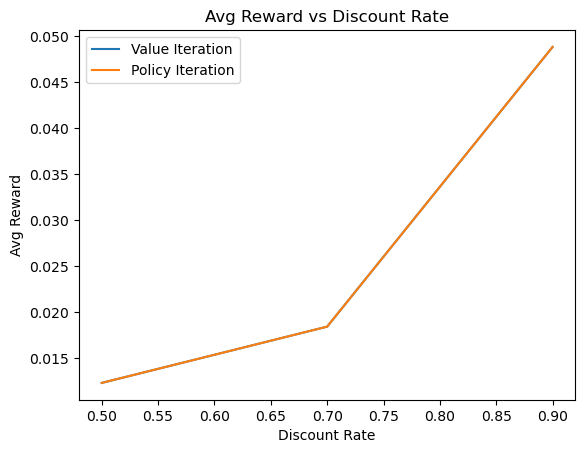

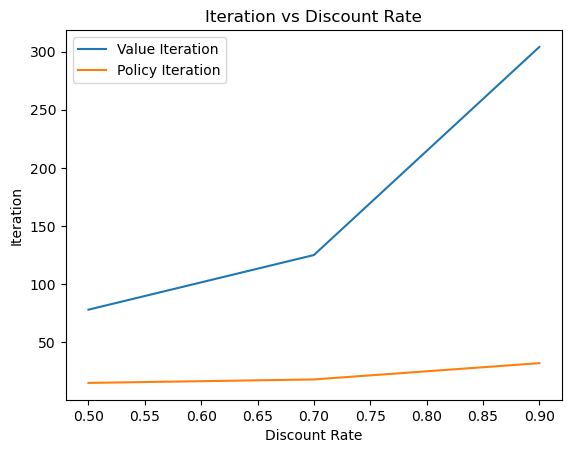

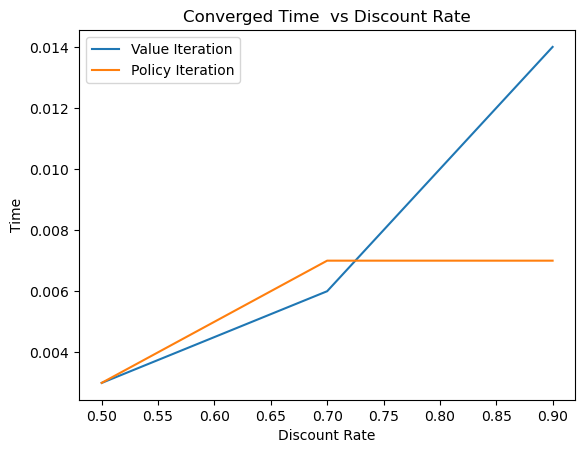

In [7]:
vi_gamma_report = iter_gamma(P_10,R_10,0)
pi_gamma_report = iter_gamma(P_10,R_10,1)
plot_iter(gamma,[vi_gamma_report[:3],pi_gamma_report[:3]],2)


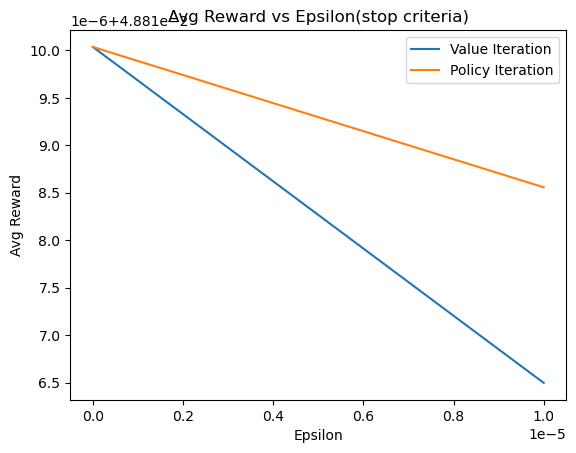

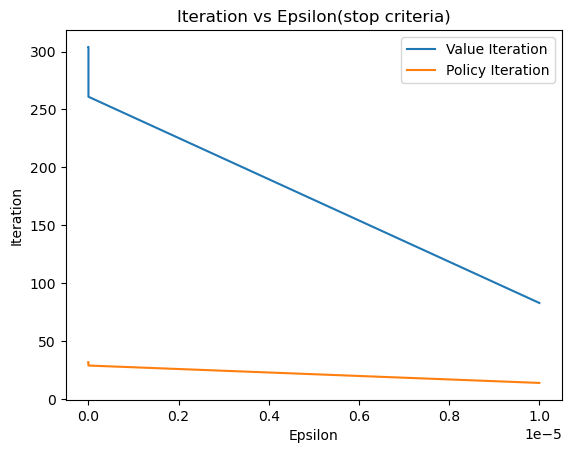

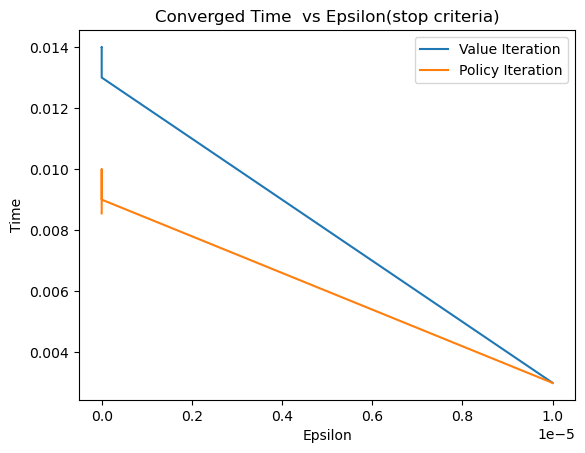

In [8]:
vi_ep_report = iter_epsilon(P_10,R_10,0)
pi_ep_report = iter_epsilon(P_10,R_10,1)
plot_ep(epsilon,[vi_ep_report[:3],pi_ep_report[:3]],2)

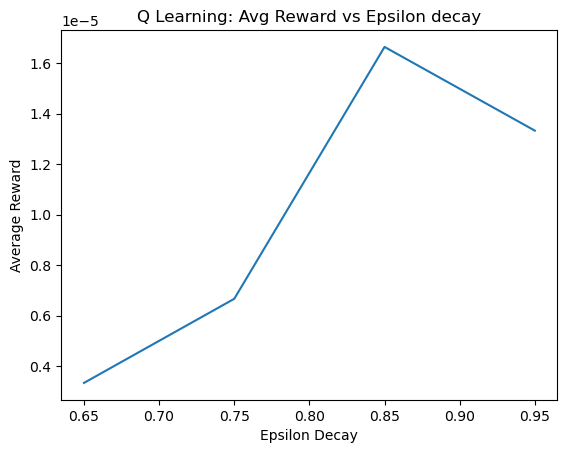

In [9]:
q_decay_result = q_iter_decay(P_10,R_10)

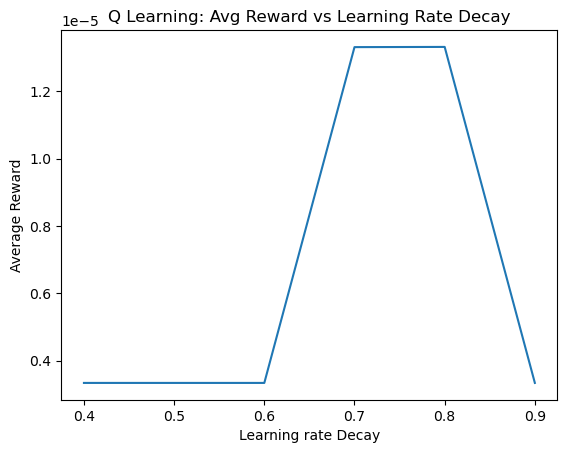

In [14]:
q_alpha_result = q_iter_alpha(P_10,R_10)

In [6]:
def compare_all(P,R,e_decay=1-10**-5, a_decay=1-10**-7.5, m_iter=100000):
    v = mdptoolbox.mdp.ValueIteration(P,R,0.9, epsilon=10**-30)
    p = mdptoolbox.mdp.PolicyIterationModified(P,R,0.9, epsilon= 10**-30)
    q = hiive.mdptoolbox.mdp.QLearning(P, R, 0.9, epsilon=1.0, epsilon_decay=e_decay, alpha=0.1, alpha_decay= a_decay, skip_check=True)
    # iter = 400000
    q.max_iter=m_iter
    v.run()
    p.run()
    q.run()
    print(f"Average Reward of Value Iteration : {round(np.mean(v.V),5)}")
    print(f"Average Reward of Policy Iteration : {round(np.mean(p.V),5)}")
    print(f"Average Reward of Q Learning : {round(np.mean(q.V),5)}")    
    
    stats = q.run_stats
    qvalue = []
    rewards = []
    errors=[]
    eps=[]
    al=[]
    for i in stats:
        eps.append(i['Epsilon'])
        al.append(i['Alpha'])
        qvalue.append(i['Mean V'])
        rewards.append(i['Reward'])
        errors.append(i['Error'])
    plt.figure()
    plt.title("Epsilon vs Iteration")
    plt.plot(range(m_iter), eps)
    plt.xlabel("Iteration")
    plt.ylabel("Epsilon")
    plt.figure()
    plt.title("Average Reward vs Iteration")
    plt.plot(range(m_iter), qvalue)
    plt.xlabel("Iteration")
    plt.ylabel("Average Reward")    

    return v,p,q

Average Reward of Value Iteration : 0.05
Average Reward of Policy Iteration : 0.05
Average Reward of Q Learning : 0.05


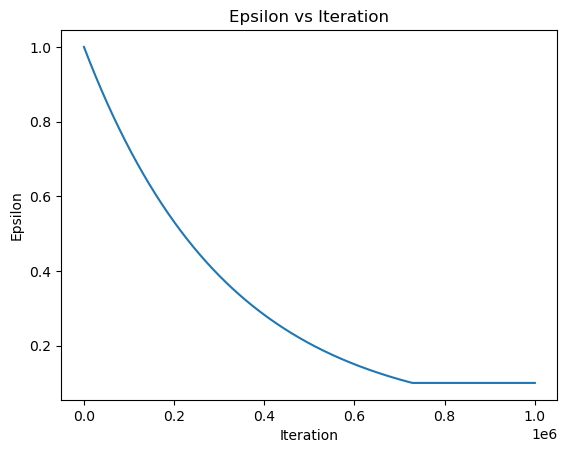

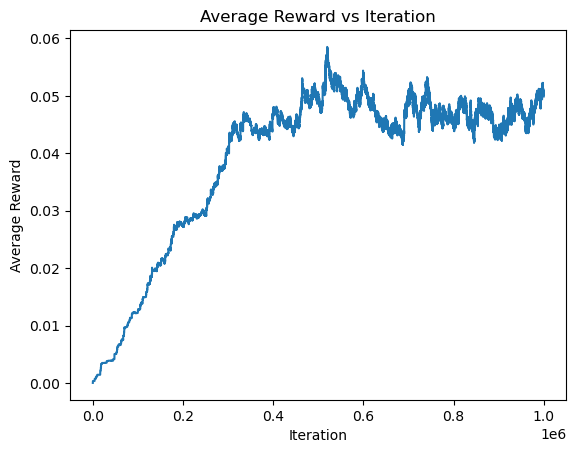

In [20]:
mdps = compare_all(P_10,R_10,e_decay=1-10**-5.5,a_decay=1-10**-7.5, m_iter=1000000)

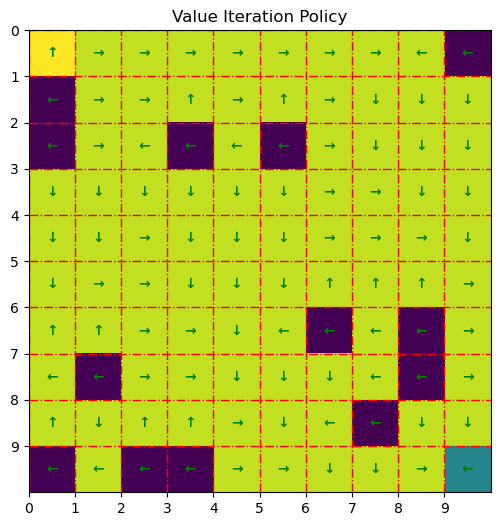

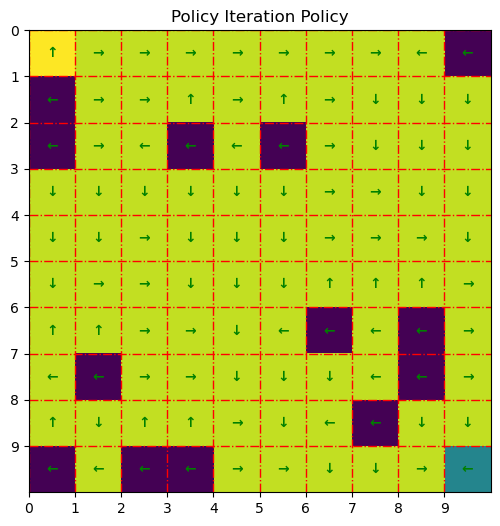

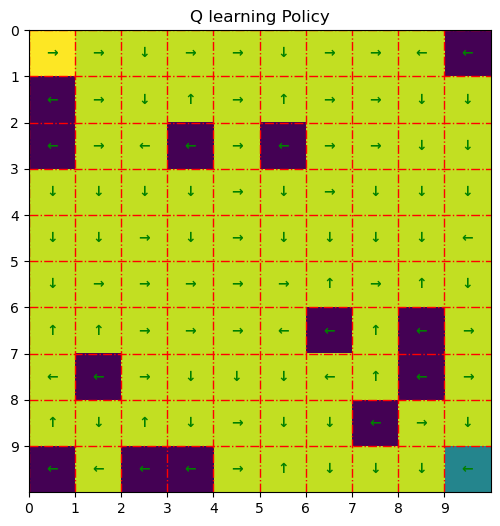

In [21]:
labels_policy=['Value Iteration Policy','Policy Iteration Policy','Q learning Policy']
for i in range(3):
    policy_display(random_map_10, mdps[i].policy, labels_policy[i])

# Frozen Lake 50 X 50

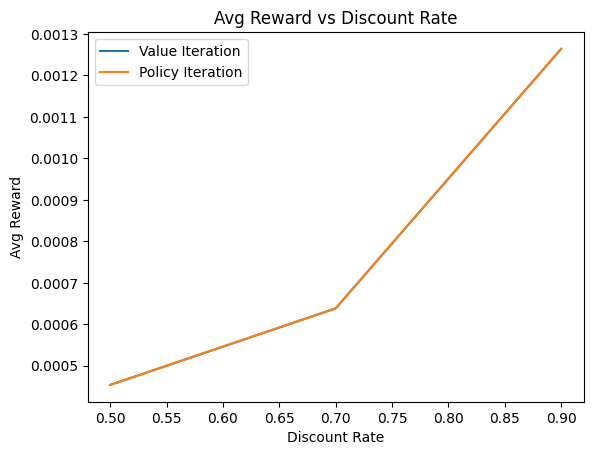

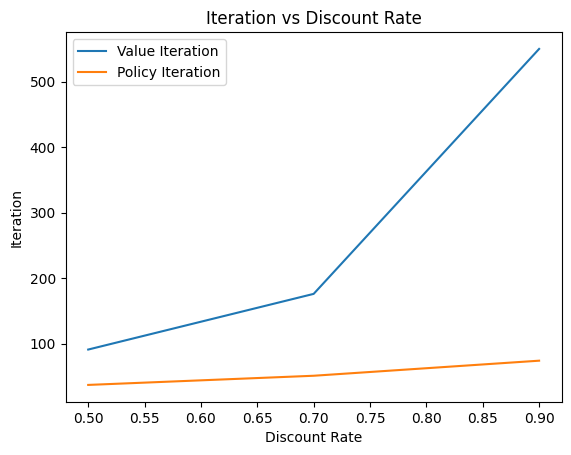

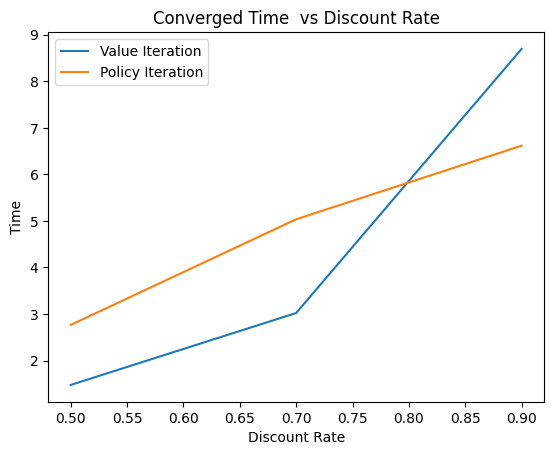

In [10]:
vi_report = iter_gamma(P_50,R_50,0)
pi_report = iter_gamma(P_50,R_50,1)
plot_iter(gamma,[vi_report,pi_report],2)

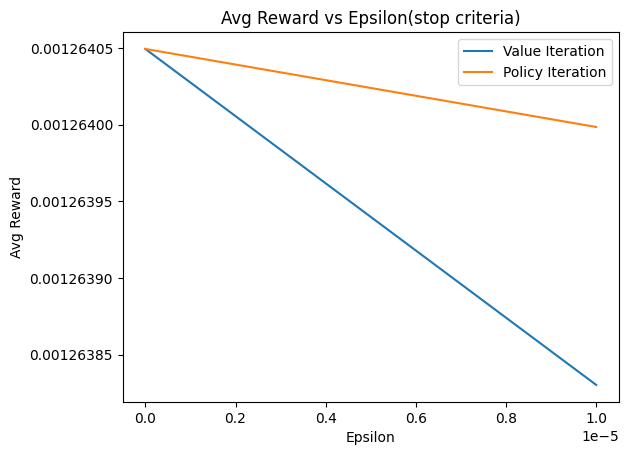

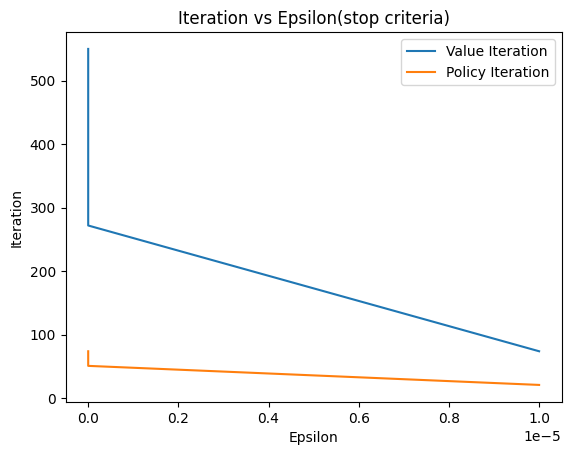

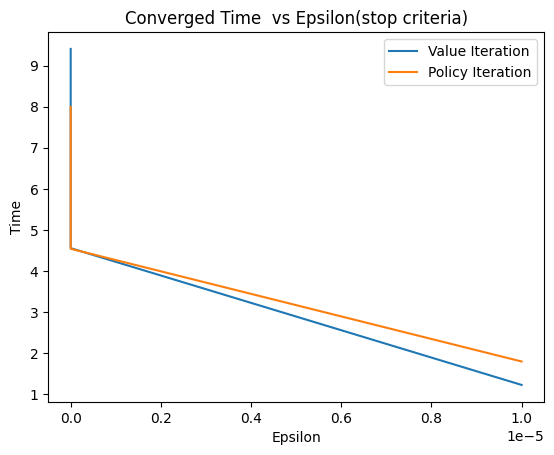

In [11]:
vi_ep_report = iter_epsilon(P_50,R_50,0)
pi_ep_report = iter_epsilon(P_50,R_50,1)
plot_ep(epsilon,[vi_ep_report,pi_ep_report],2)

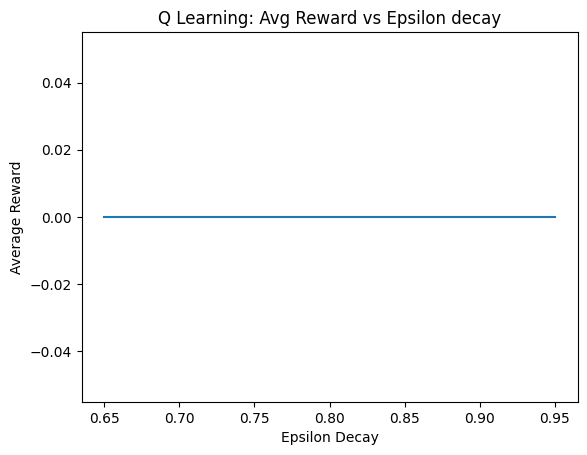

In [12]:
q_iter_decay(P_50,R_50)

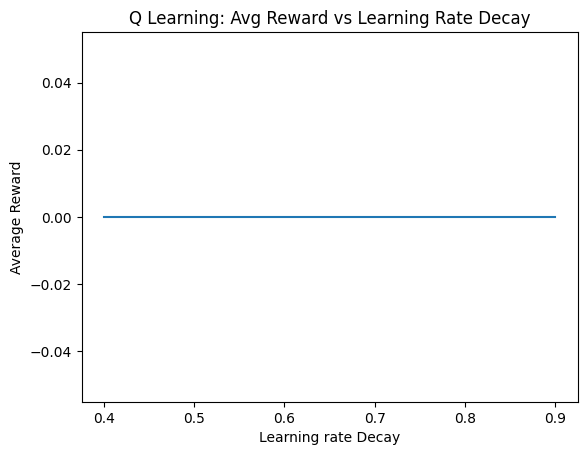

In [13]:
q_iter_alpha(P_50,R_50)

In [7]:
P=P_50
R=R_50
e_decay=1-10**-5.8
a_decay=1-10**-8
m_iter=3000000
v = mdptoolbox.mdp.ValueIteration(P,R,0.9, epsilon=10**-30)
p = mdptoolbox.mdp.PolicyIterationModified(P,R,0.9, epsilon= 10**-30)
q = hiive.mdptoolbox.mdp.QLearning(P, R, 0.9, epsilon=1.0, epsilon_decay=e_decay, alpha=1, alpha_decay= a_decay, skip_check=True)
# iter = 400000
q.max_iter=m_iter
v.run()
p.run()
q.run()
print("")

Average Reward of Value Iteration : 0.00244
Average Reward of Policy Iteration : 0.00244
Average Reward of Q Learning : 0.00177


Text(0, 0.5, 'Average Reward')

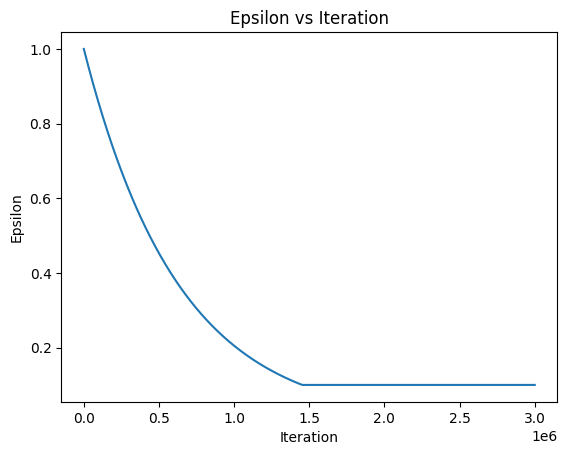

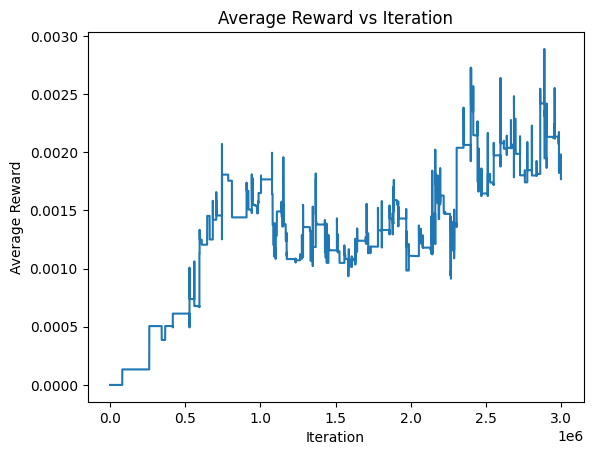

In [8]:
v_policy = v.policy
p_policy = p.policy
q_policy = q.policy

print(f"Average Reward of Value Iteration : {round(np.mean(v.V),5)}")
print(f"Average Reward of Policy Iteration : {round(np.mean(p.V),5)}")
print(f"Average Reward of Q Learning : {round(np.mean(q.V),5)}")
stats = q.run_stats
qvalue = []
rewards = []
errors=[]
eps=[]
al=[]
for i in stats:
    eps.append(i['Epsilon'])
    al.append(i['Alpha'])
    qvalue.append(i['Mean V'])
    rewards.append(i['Reward'])
    errors.append(i['Error'])
plt.figure()
plt.title("Epsilon vs Iteration")
plt.plot(range(m_iter), eps)
plt.xlabel("Iteration")
plt.ylabel("Epsilon")
plt.figure()
plt.title("Average Reward vs Iteration")
plt.plot(range(m_iter), qvalue)
plt.xlabel("Iteration")
plt.ylabel("Average Reward")

Text(0, 0.5, 'Reward')

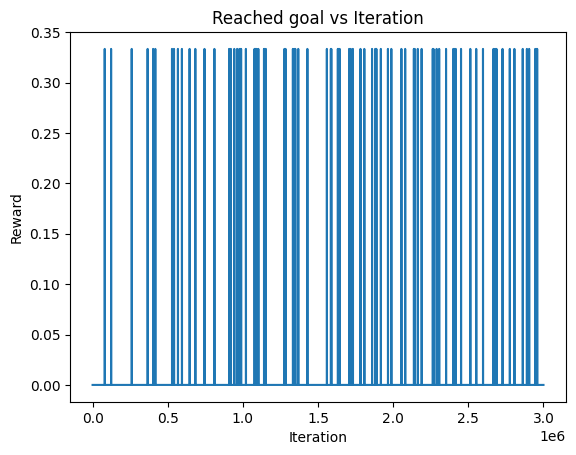

In [9]:
plt.title("Reached goal vs Iteration")
plt.plot(range(m_iter), rewards)
plt.xlabel("Iteration")
plt.ylabel("Reward")

In [10]:
np.count_nonzero(rewards)

196

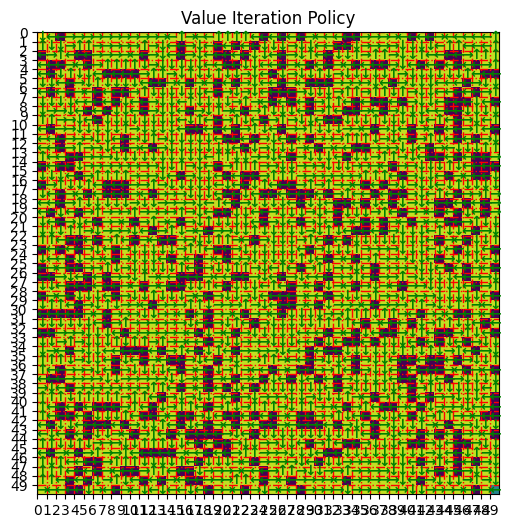

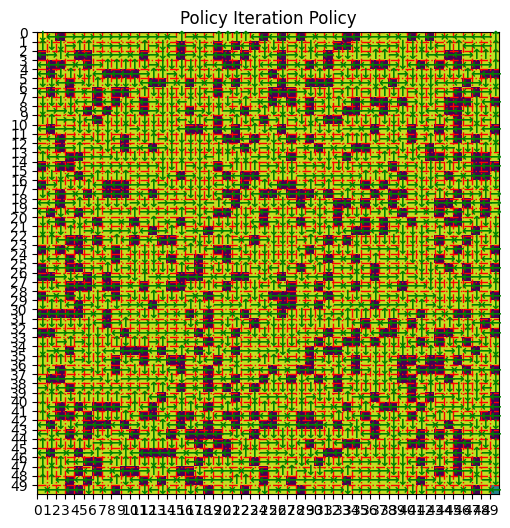

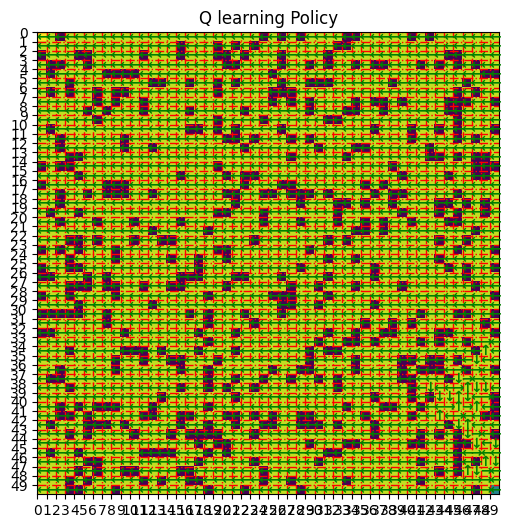

In [11]:
labels_policy=['Value Iteration Policy','Policy Iteration Policy','Q learning Policy']
mdps = [v,p,q]
for i in range(3):
    policy_display(random_map_50, mdps[i].policy, labels_policy[i])

In [11]:
print(f'VI policy : {mdps[0].policy}')
print(f'PI Policy : {mdps[1].policy}')
print(f'Q Policy : {mdps[2].policy}')

VI policy : (0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 3, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 1, 3, 2, 3, 3, 2, 2, 3, 3, 3, 2, 2, 2, 0, 0, 2, 3, 0, 0, 2, 3, 2, 2, 2, 1, 1, 1, 1, 2, 3, 2, 1, 1, 0, 0, 2, 1, 1, 1, 1, 0, 0, 1, 2, 3, 2, 1, 1, 1, 1, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 2, 1, 0, 0, 2, 1, 1, 3, 3, 0, 0, 0, 0, 2, 2, 2, 3, 1, 2, 1, 3, 0, 0, 2, 1, 3, 0, 0, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 1, 1, 1, 2, 1, 1, 0, 0, 0, 1, 2, 0, 0, 0, 2, 3, 1, 0, 0, 2, 1, 1, 1, 3, 3, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 3, 0, 0, 2, 2, 1, 1, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 2, 1, 1, 2, 1, 0, 0, 0, 0, 2, 1, 1, 2, 1, 1, 0, 0, 0, 2, 0, 0, 2, 1, 1, 0, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 3, 0, 0, 2, 1, 1, 0, 0, 0, 2, 0, 0, 2, 1, 0, 0, 2, 1, 1, 3, 3, 3, 2, 0, 0, 2, 3, 1, 3, 1, 3, 1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 1, 1, 1, 2, 0, 0, 0, 1, 0, 0, 2, 1, 2, 1, 1, 0, 0, 0, 0, 0, 1, 